## 1. Imports

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Explorar y limpiar la data

### 2.1 Leer dataset

In [41]:
df = pd.read_csv('../data/data_caso_forecast.csv')
df.sample(5,random_state=42)    

,ds,y,precio,opu,feriados,cyber,mobility,oil_price,copper_price,perc_zero_stock
56,25-01-2021,6302,30380.84931,0.000000,0,0,-45.622061,52.554,3.5693,0.698347
89,13-09-2021,18982,27887.79588,0.724138,3,0,-21.969231,71.620,4.3039,0.083352
4,27-01-2020,0,26016.26202,0.137931,0,0,0.000000,52.730,2.6188,0.019411
45,09-11-2020,33422,28043.43321,0.000000,0,0,-39.406872,40.870,3.1800,0.245966
26,29-06-2020,13466,27311.80357,0.000000,1,0,-66.242315,39.944,2.7767,0.033333


### 2.2 Chequear types

De acuerdo al desafio se tiene lo siguiente:
- **ds**: semana de venta (fecha del primer día de la semana) &rarr; **datetime** 
- **y**: cantidad vendida en el periodo &rarr; **integer**
- **precio**: precio promedio de venta del periodo &rarr; **float**
- **opu**: porcentaje de los productos de la categoría que estuvieron en promoción &rarr; **float**
- **feriados**: indica el número de feriados que hubo en el periodo &rarr; **integer**
- **cyber**: variable dummy, indica si hubo cyber en el periodo &rarr; **integer (binary)**
- **mobility**: indicador de mobilidad de google (variable pandémica) &rarr; **float**
- **oil_price**: precios del petróleo &rarr; **float**
- **copper_price**: precios del cobre &rarr; **float**
- **perc_zero_stock**: porcentaje de tiendas con quiebre &rarr; **float**

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ds               118 non-null    object 
 1   y                118 non-null    int64  
 2   precio           118 non-null    object 
 3   opu              118 non-null    float64
 4   feriados         118 non-null    int64  
 5   cyber            118 non-null    int64  
 6   mobility         118 non-null    float64
 7   oil_price        118 non-null    float64
 8   copper_price     118 non-null    float64
 9   perc_zero_stock  118 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 9.3+ KB


De esta forma vamos a convertir en el tipo de dato correspondiente donde sea posible.

In [43]:
# Fechas en datetime
df['ds'] = pd.to_datetime(df.ds, format='%d-%m-%Y')

# Convertir en int
df['y'] = df['y'].astype(int) 
df['feriados'] = df['feriados'].astype(int) 
df['cyber'] = df['cyber'].astype(int) 

# Convertir float
df['opu'] = df['opu'].astype(float)
df['mobility'] = df['mobility'].astype(float)
df['oil_price'] = df['oil_price'].astype(float)
df['copper_price'] = df['copper_price'].astype(float)
df['perc_zero_stock'] = df['perc_zero_stock'].astype(float)


Donde la variable "precio" no fue posible convertir dado que cuenta con unos valores "#N/D"

In [44]:
df[df['precio'] == '#N/D']

,ds,y,precio,opu,feriados,cyber,mobility,oil_price,copper_price,perc_zero_stock
0,2019-12-30,6038,#N/D,0.0,1,0,0.0,61.660,2.8492,0.155448
1,2020-01-06,12040,#N/D,0.0,0,0,0.0,60.836,2.8521,0.095997


Los cuales corresponden a la última semana del año 2019 y la primera del 2020, que para este dataset son los primeros datos. Ya que el dataset es muy pequeño estos 2 datos corresponden cerca del 2% de los datos. En una primera instancia se podría buscar la forma de no perder esta data pero en este caso sería extrapolando lo cual no aportaría mucho en este caso, de esta forma se opta por eliminar esas filas.

In [45]:
# Eliminar esas filas
df = df[df['precio'] != '#N/D'].reset_index(drop=True)

# Convertir float
df['precio'] = df['precio'].astype(float)

De esta forma vemos que no hay nan values

In [46]:
df.isna().sum()

ds                 0
y                  0
precio             0
opu                0
feriados           0
cyber              0
mobility           0
oil_price          0
copper_price       0
perc_zero_stock    0
dtype: int64

### 2.3 Visualizar Data

Ahora visualicemoslos timeseries

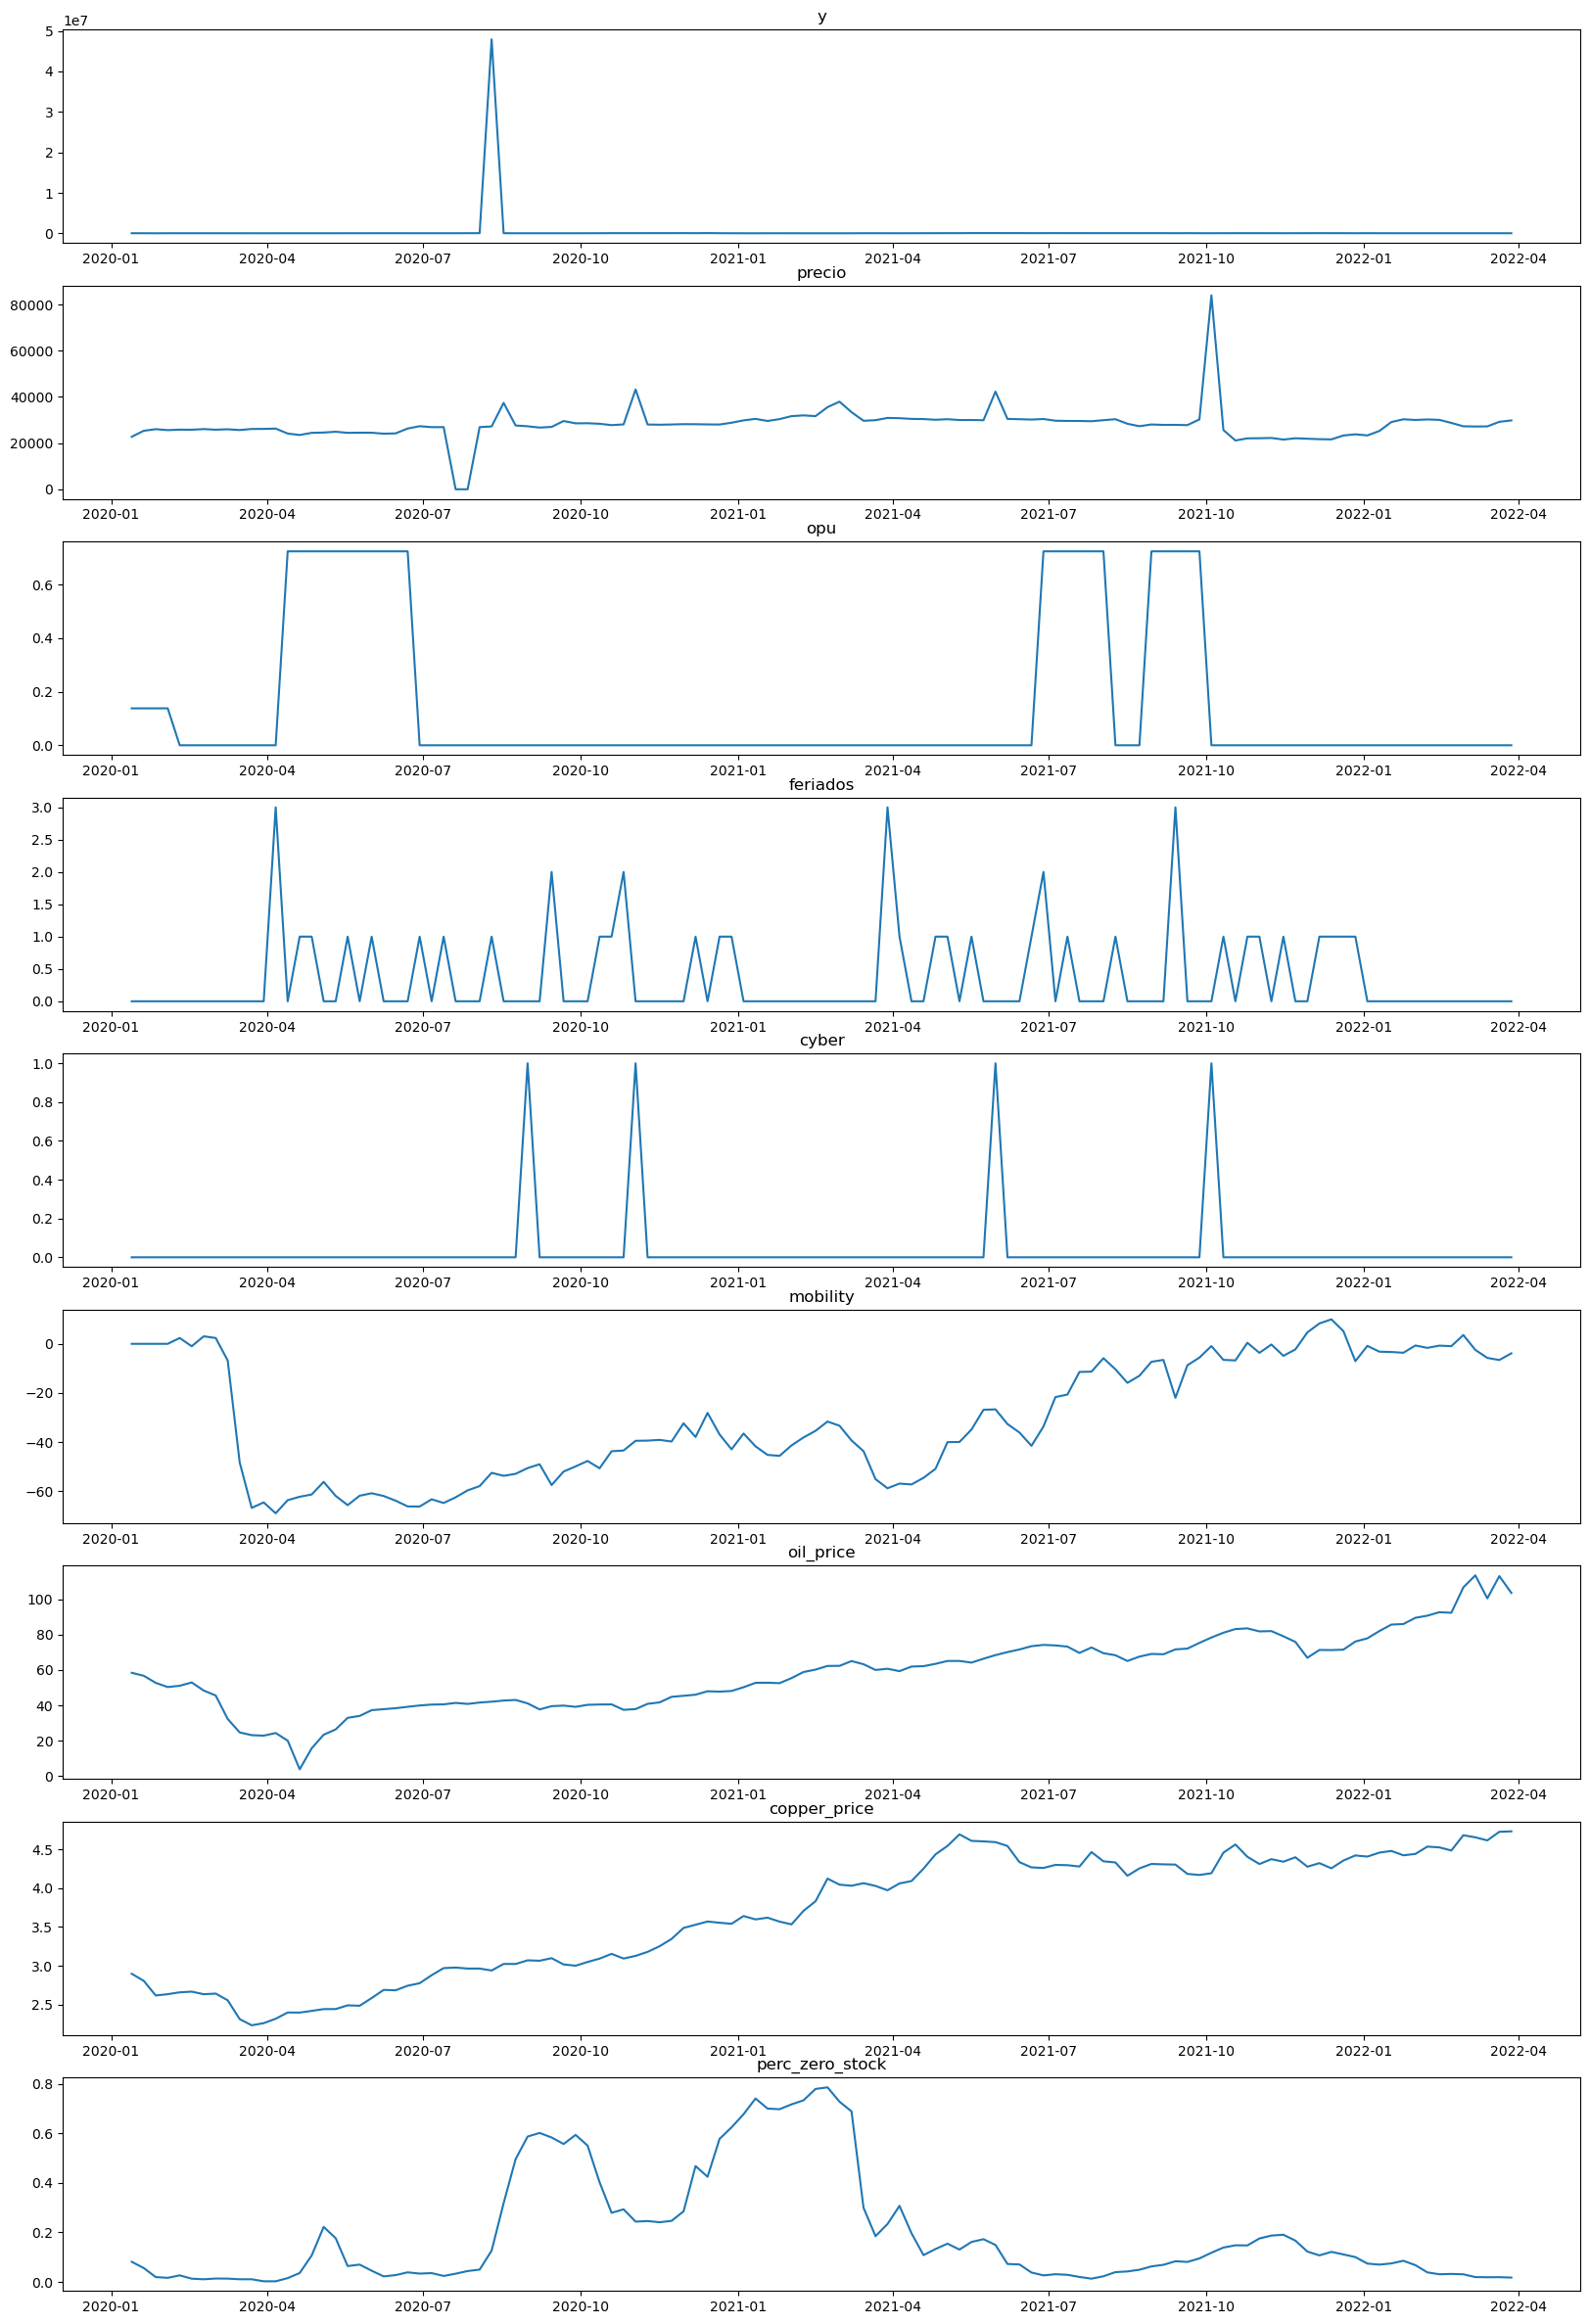

In [47]:
# Crear todos los timeseries
fig, axs = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(20, 30))
for i, col in enumerate(df.columns[1:]):
    axs[i].plot(df.ds,df[col])
    axs[i].set_title(col)

A priori pareceria un outlier el pico que se ve en la variable 'y', veamos sus valores vecinos

In [60]:
index = df[df['y'] == df.y.max()].index[0]
df.iloc[index-2:index+3]

,ds,y,precio,opu,feriados,cyber,mobility,oil_price,copper_price,perc_zero_stock
28,2020-07-27,20986,0.00000,0.0,0,0,-59.661844,40.820,2.9654,0.043708
29,2020-08-03,29168,26910.32864,0.0,0,0,-57.920434,41.614,2.9653,0.049567
30,2020-08-10,47912000,27213.84145,0.0,1,0,-52.540687,42.094,2.9402,0.126386
31,2020-08-17,20724,37410.42649,0.0,0,0,-53.745597,42.726,3.0250,0.318210
32,2020-08-24,7654,27615.37377,0.0,0,0,-52.937984,43.074,3.0242,0.496546


La cual es 3 ordenes de magnitud más grande que los vecinos y vemos que lo único que no esta en la tendencia de los datos es que hay un feriado, lo cual dificilmente podría explicar ese valor, en una primera impresión parece un error de tipeo donde los '0' no corresponden, de esta forma para no perder ese dato solo eliminaremos los 0.

In [61]:
df.loc[index,'y'] = 47912

Ahora la data se visualiza de esta forma

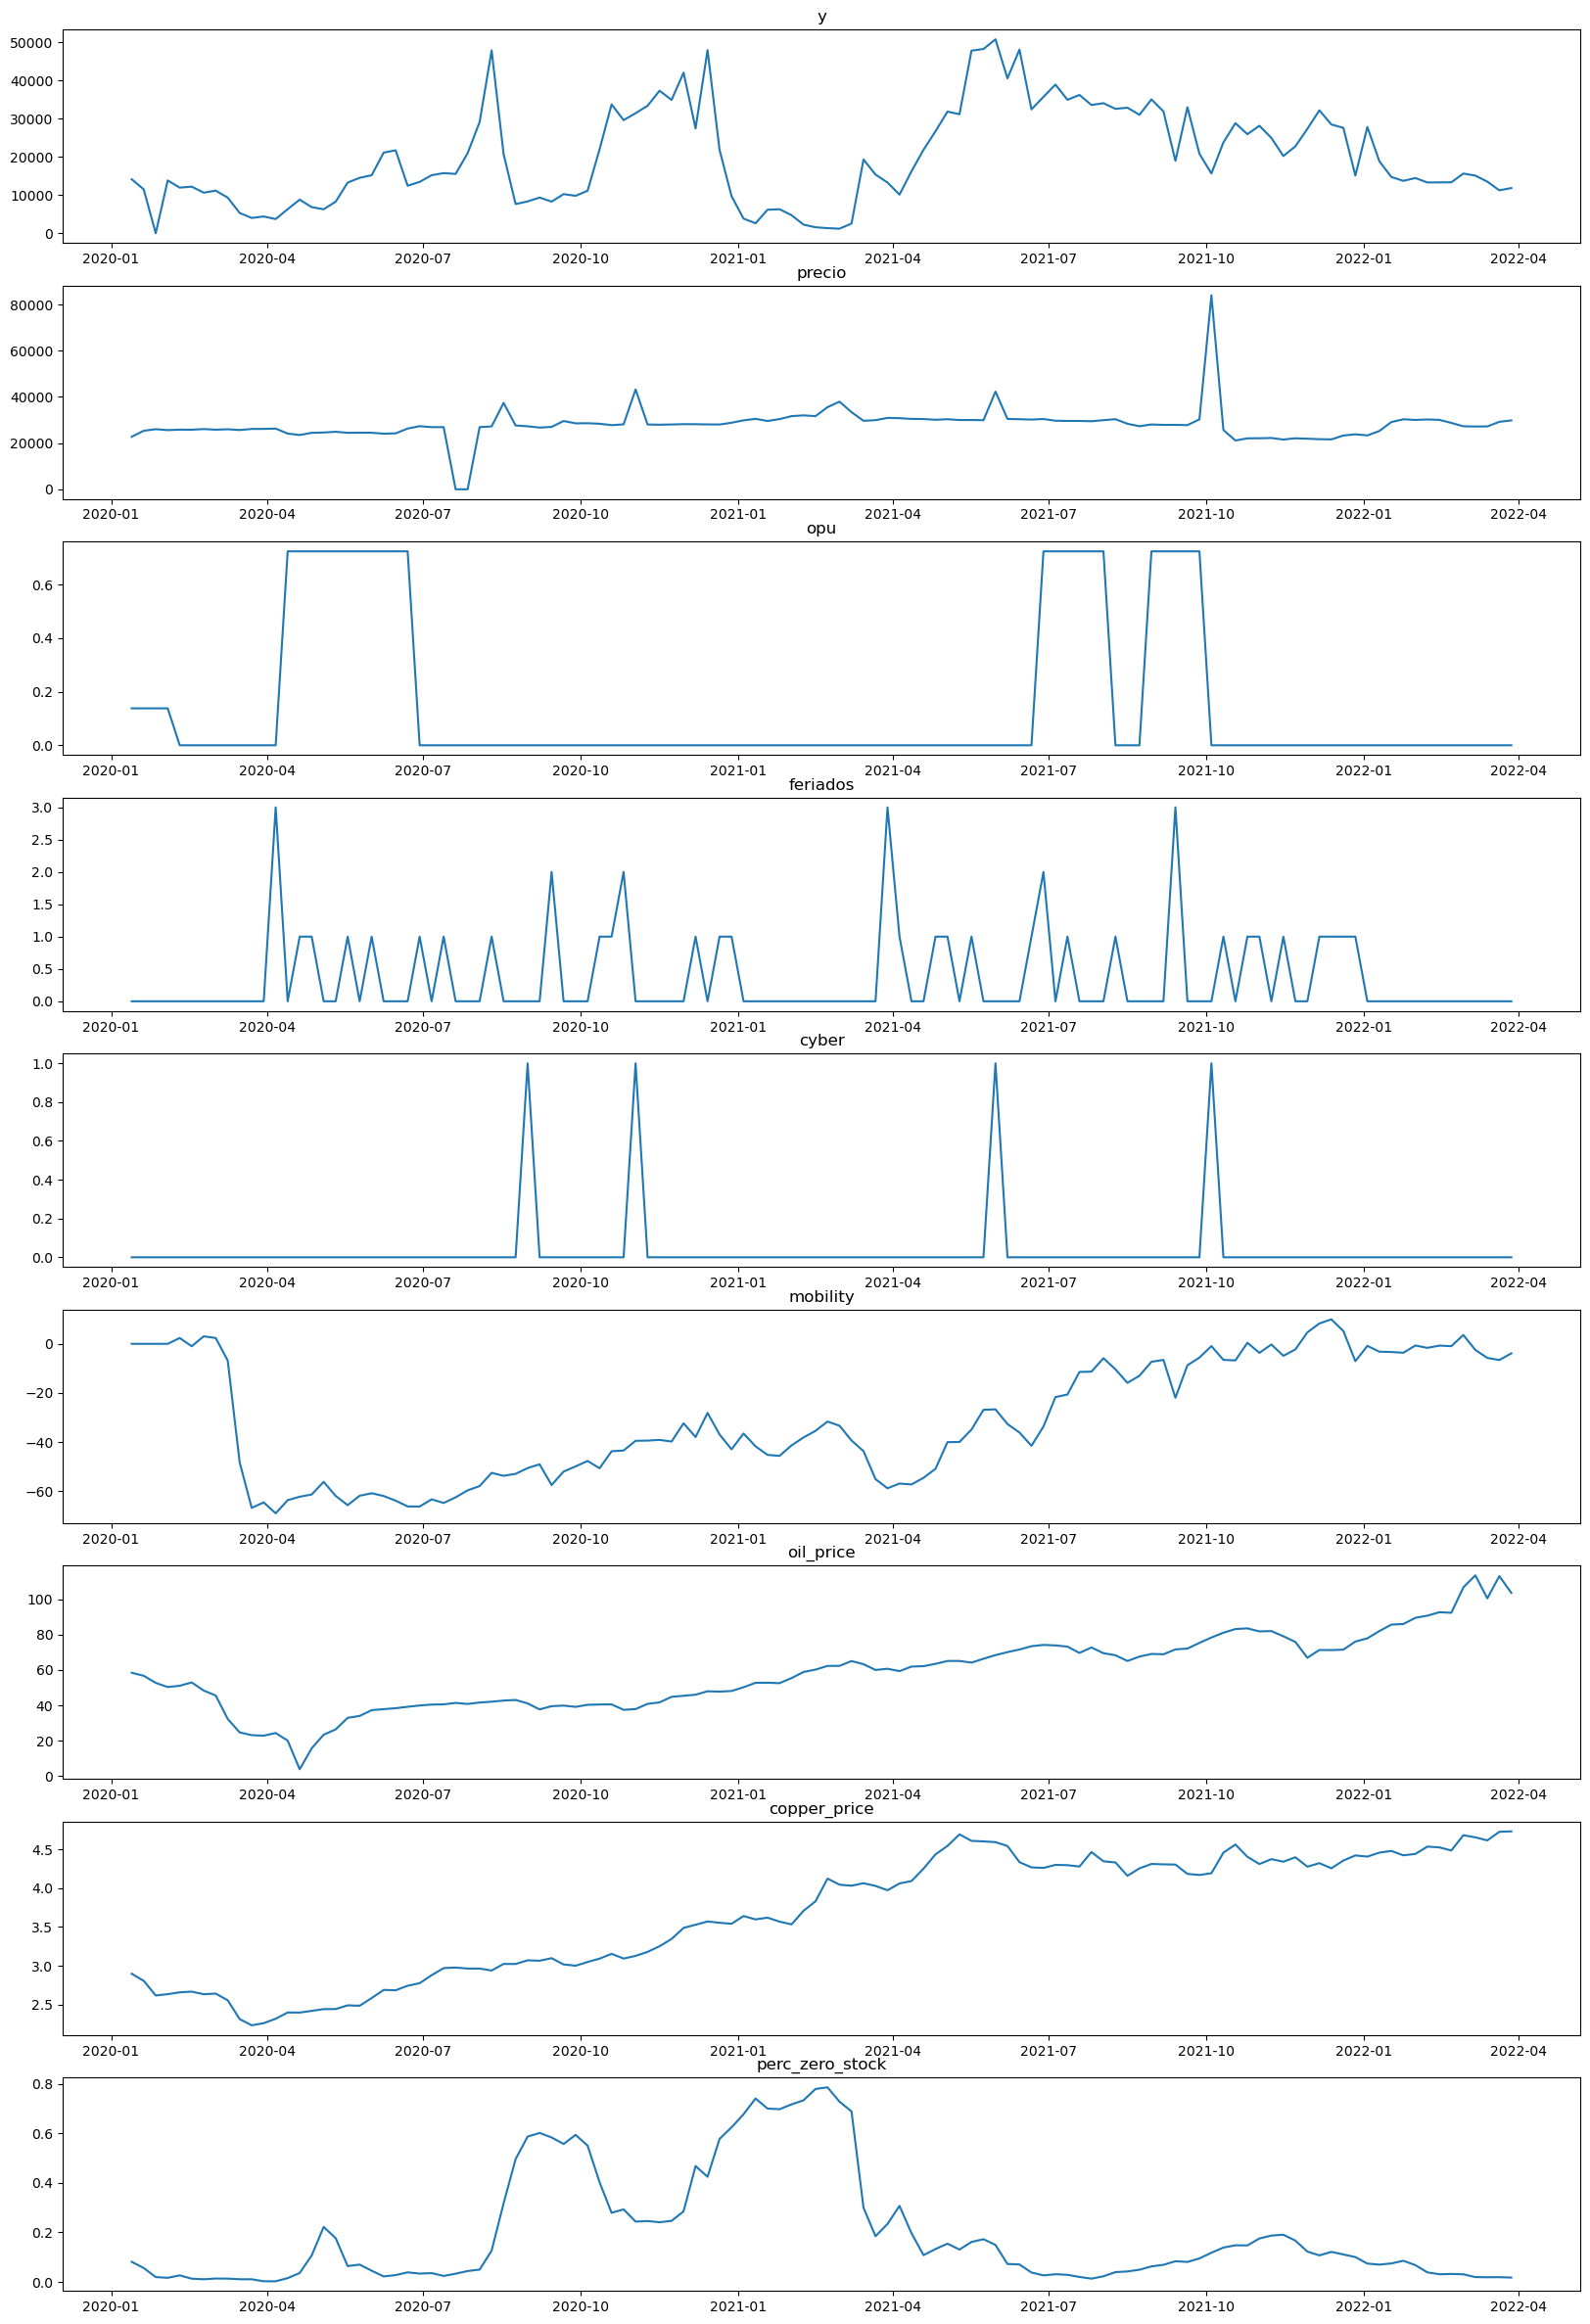

In [63]:
# Crear todos los timeseries
fig, axs = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(20, 30))
for i, col in enumerate(df.columns[1:]):
    axs[i].plot(df.ds,df[col])
    axs[i].set_title(col)